## Modeling

For all the models I tested, I ran a `Pipeline` through a `Gridsearch`.

In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
import regex as re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

sns.set_style(style = 'whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
df = pickle.load(open('../assets/clean_df.pkl', 'rb'))

In [5]:
df.head()

,all_text,subreddit,char_count,word_count,created_utc
0,late night laundry,1,28,4,1580239970
1,why the moon disappear part one,1,48,8,1580239486
2,you t die of old age part,1,43,9,1580239395
3,why the moon disappear true story part one,1,61,10,1580238771
4,the door to hell,1,17,4,1580237605


### Train Test Split

In [6]:
X = df['all_text']
y = df['subreddit']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

#### Define the baseline.
Using `.valuecounts(normalize=True)` on the target variable, I set a baseline for the model to surpass. The baseline is `1 : 0.504647` and `0 : 0.495353`.

In [10]:
df['subreddit'].value_counts(normalize=True)

1    0.504647
0    0.495353
Name: subreddit, dtype: float64

In [12]:
# Baseline
y_test.value_counts(normalize=True)

1    0.508081
0    0.491919
Name: subreddit, dtype: float64

## `CountVectorizer` & `LogisticRegression` Pipeline

- For the first model, I used `CountVectorizer` and `LogisticRegression` with a set of parameters and got a training score of `0.7198` and a test score of `0.7218`.

In [14]:
%%time
pipe_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])

# Original params that I Gridsearched but I am commenting them out
# because I have to rerun my cells and I don't want it to take forever
# pipe_cvec_params = {
#     'cvec__max_features': [100, 500],
#     'cvec__ngram_range': [(1,1), (1,2)],
#     'cvec__stop_words': ['english']
# }

pipe_cvec_params = {
    'cvec__max_features': [100],
    'cvec__ngram_range': [(1,1)],
    'cvec__stop_words': ['english']
}

gs_cvec = GridSearchCV(pipe_cvec,
                      pipe_cvec_params,
                      cv=5)

gs_cvec.fit(X_train, y_train)

gs_cvec.best_score_

gs_cvec_model = gs_cvec.best_estimator_

print(f'Best Params:\n{gs_cvec.best_params_}')
print('')
print(f' CountVectorizer Train Score: {gs_cvec_model.score(X_train, y_train)}')
print('')
print(f' CountVectorizer Test Score: {gs_cvec_model.score(X_test, y_test)}')

Best Params:
{'cvec__max_features': 100, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}

 CountVectorizer Train Score: 0.7179418103448276

 CountVectorizer Test Score: 0.7177777777777777
CPU times: user 47.5 s, sys: 726 ms, total: 48.2 s
Wall time: 50.2 s


- Best Params:
`{'cvec__max_features': 100, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}`

- CountVectorizer Train Score: `0.7198949353448276`

- CountVectorizer Test Score: `0.7218181818181818`

#### Pickle `gs_cvec_model` model

In [15]:
pickle.dump(gs_cvec_model, open('../assets/gs_cvec_model.sav', 'wb'))

#### Open model pickle

In [16]:
gs_cvec_model = pickle.load(open("../assets/gs_cvec_model.sav", "rb"))

## `Count Vectorizere` & `RandomForestClassifier` Pipeline
- For the second model I used `CountVectorizer` and `RandomForestClassifier` with a set of parameters and got a training score of `0.9415` and a test score of `0.7561`.

In [18]:
%%time
pipe_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_rf_params = {
    'cvec__max_features': [500],
    'cvec__ngram_range': [(1,2)],
    'cvec__stop_words': ['english'],
    'rf__n_estimators': [125],
    'rf__max_depth': [None],
    'rf__max_features': ['auto']
}

# Original params that I Gridsearched but I am commenting them out
# because I have to rerun my cells and I don't want it to take forever

# pipe_rf_params = {
#     'cvec__max_features': [100, 500],
#     'cvec__ngram_range': [(1,1), (1,2)],
#     'cvec__stop_words': ['english'],
#     'rf__n_estimators': [100, 125],
#     'rf__max_depth': [None, 4, 5, 6],
#     'rf__max_features': ['auto']
# }


gs_rf = GridSearchCV(pipe_rf,
                      pipe_rf_params,
                      cv=3)

gs_rf.fit(X_train, y_train)

gs_rf.best_score_

gs_rf_model = gs_rf.best_estimator_

print(f'Best Params:\n{gs_rf.best_params_}')
print('')
print(f' CountVectorizer Train Score: {gs_rf_model.score(X_train, y_train)}')
print('')
print(f' CountVectorizer Test Score: {gs_rf_model.score(X_test, y_test)}')

Best Params:
{'cvec__max_features': 500, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__n_estimators': 125}

 CountVectorizer Train Score: 0.9415409482758621

 CountVectorizer Test Score: 0.7561616161616161
CPU times: user 3min 47s, sys: 3.42 s, total: 3min 51s
Wall time: 3min 59s


- Best Params:
`{'cvec__max_features': 500, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__n_estimators': 125}`

- CountVectorizer Train Score: `0.9455818965517241`

- CountVectorizer Test Score: `0.7543434343434343`

#### Random forest pickle

In [13]:
pickle.dump(gs_rf_model, open('../assets/gs_rf_model.sav', 'wb'))


#### Import random forest pickle

In [14]:
gs_rf_model = pickle.load(open("../assets/gs_rf_model.sav", "rb"))

## `CountVectorizer` & `ExtraTreesClassifier` Pipeline
- For the third model I used `CountVectorizer` and `ExtraTreesClassifier` with a set of parameters and got a training score of `0.9462` and a test score of `0.7569`.


In [15]:
et = ExtraTreesClassifier()

In [16]:
%%time

pipe_et = Pipeline([
    ('cvec', CountVectorizer()),
    ('et', ExtraTreesClassifier())
])

pipe_et_params = {
    'cvec__max_features': [500], 
     'cvec__ngram_range': [(1,1), (1, 2)], 
     'cvec__stop_words': ['english'], 
     'et__max_depth': [None], 
     'et__max_features': ['auto'], 
     'et__n_estimators': [125]
}


gs_et = GridSearchCV(pipe_et,
                      pipe_et_params,
                      cv=3)

gs_et.fit(X_train, y_train)

gs_et.best_score_

gs_et_model = gs_et.best_estimator_

print(f'Best Params:\n{gs_et.best_params_}')
print('')
print(f' CountVectorizer Train Score: {gs_et_model.score(X_train, y_train)}')
print('')
print(f' CountVectorizer Test Score: {gs_et_model.score(X_test, y_test)}')

Best Params:
{'cvec__max_features': 500, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'et__max_depth': None, 'et__max_features': 'auto', 'et__n_estimators': 125}

 CountVectorizer Train Score: 0.9462553879310345

 CountVectorizer Test Score: 0.756969696969697
CPU times: user 5min 34s, sys: 3.38 s, total: 5min 37s
Wall time: 5min 44s


- Best Params:
`{'cvec__max_features': 500, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'et__max_depth': None, 'et__max_features': 'auto', 'et__n_estimators': 125}`

- CountVectorizer Train Score: `0.9462553879310345`

- CountVectorizer Test Score: `0.756969696969697`

#### Extra trees pickle

In [17]:
pickle.dump(gs_et_model, open('../assets/gs_et_model.sav', 'wb'))


#### Import extra trees pickle

In [18]:
gs_et_model = pickle.load(open("../assets/gs_et_model.sav", "rb"))

## Sentiment Analysis

In [19]:
%%time
sia = SentimentIntensityAnalyzer()

# From Daniel's Advanced Pipes Lesson.
# Write a function to get the compound sentiment scores for a post

# Since sentiment score returns a dictionary, we are just calling the 'compound' key that gives
# the compound sentiment score
def get_compound_sentiment(post):
    return sia.polarity_scores(post)['compound']

# Create new column that applies the function to every 
# observation in the 'all_text' column.
df['sentiment'] = df['all_text'].apply(get_compound_sentiment)
df['sentiment'].describe()

CPU times: user 3min 55s, sys: 1.07 s, total: 3min 56s
Wall time: 4min


count    19798.000000
mean        -0.229466
std          0.732794
min         -1.000000
25%         -0.984400
50%         -0.306900
75%          0.361200
max          1.000000
Name: sentiment, dtype: float64

### Sentiment Histograms and Mean Bar Graphs

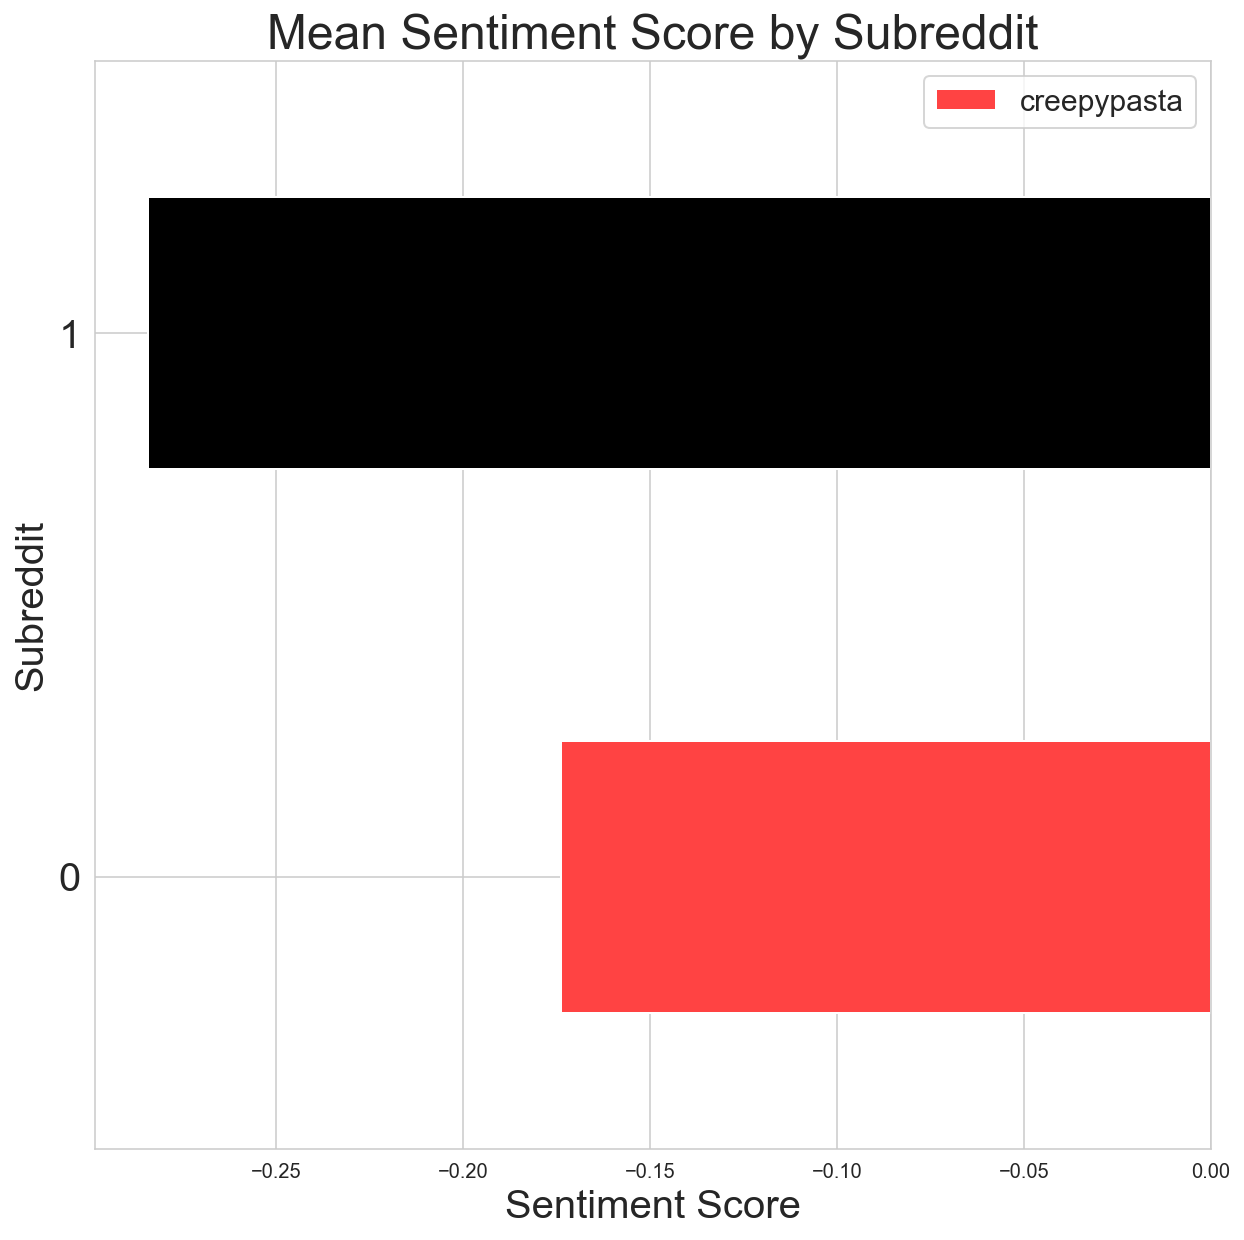

In [20]:
df.groupby('subreddit')['sentiment'].mean().plot(kind='barh', 
                                                 color = ['#FF4343', 'black'], 
                                                 figsize=(10,10))
plt.ylabel('Subreddit', fontsize = 20)
plt.xlabel('Sentiment Score', fontsize = 20)
plt.title('Mean Sentiment Score by Subreddit', fontsize = 24)
plt.legend(['creepypasta', 'nosleep'], fontsize =15)
plt.yticks(fontsize = 20)
plt.savefig('../images/mean_sentiment.png');

>Subreddit 1 is slightly more negative on average, which can help the model identify where the post came from.

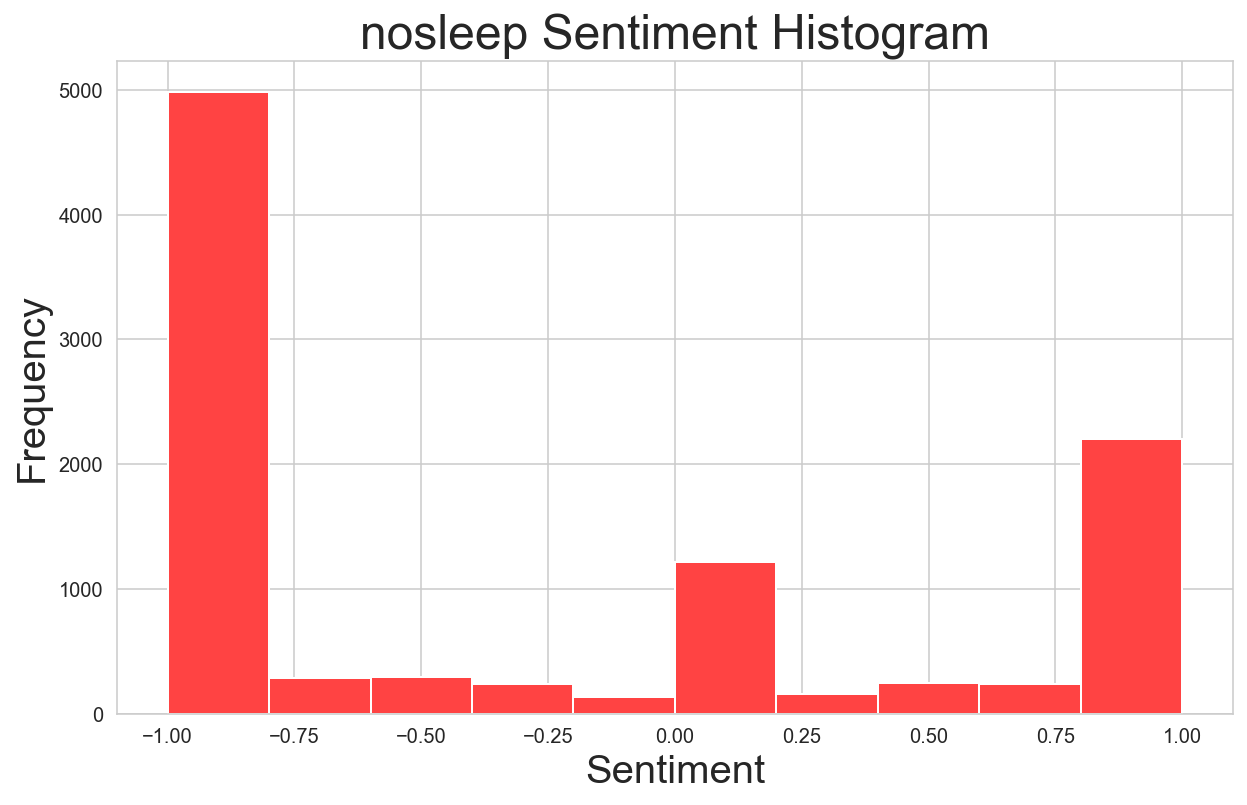

In [21]:
df[df['subreddit']==1].groupby('subreddit')['sentiment'].plot(kind='hist', 
                                                              color = ['#FF4343'], 
                                                         figsize=(10,6))
plt.title('nosleep Sentiment Histogram', fontsize=24)
plt.xlabel('Sentiment', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.savefig('../images/nosleep_sentiment.png');

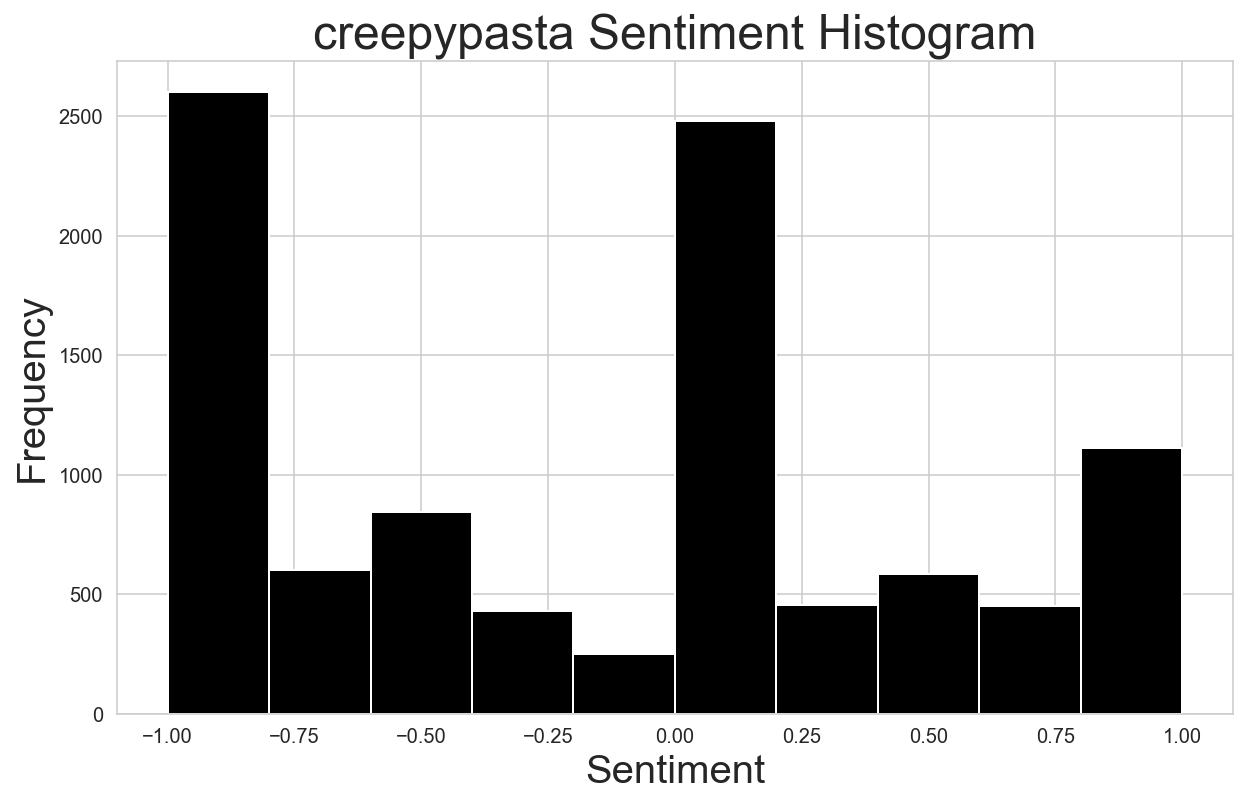

In [22]:
df[df['subreddit']==0].groupby('subreddit')['sentiment'].plot(kind='hist', color = 'black',
                                                             figsize=(10,6))
plt.title('creepypasta Sentiment Histogram', fontsize=24)
plt.xlabel('Sentiment', fontsize=20)
plt.ylabel('Frequency', fontsize=20);
plt.savefig('../images/creepypasta_sentiment.png');

In [23]:
%%time

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

params = {
#     'logreg__penalty': ['l1', 'l2']
    'logreg__penalty': ['l2']
}

gs = GridSearchCV(pipe, params, cv=5)

gs.fit(X_train, y_train)
gs.score(X_train, y_train)
gs.score(X_test, y_test)

/Users/mariaflores/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mariaflores/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaflores/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mariaflores/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaflores/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver

CPU times: user 2min 34s, sys: 1.42 s, total: 2min 35s
Wall time: 1min 48s


0.7452525252525253

In [34]:
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.9958243534482759
0.776969696969697


In [24]:
%%time
# build a function to print out a nice confusion matrix
preds = gs.best_estimator_.predict(X_test)

def nice_conmat(y_test, preds, classes):
    conmat = confusion_matrix(y_test, preds)
    print(f'Accuracy Score: {accuracy_score(y_test, preds)}')
    return pd.DataFrame(conmat, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])
nice_conmat(y_test, preds, ['creepypasta', 'nosleep'])

Accuracy Score: 0.7452525252525253
CPU times: user 2.59 s, sys: 41.2 ms, total: 2.63 s
Wall time: 2.7 s


,Predicted creepypasta,Predicted nosleep
Actual creepypasta,2043,392
Actual nosleep,869,1646


### Create DataFrame to Graph Coefficients

In [25]:
%%time
# look at the coefficients
coefs = gs.best_estimator_.named_steps['logreg'].coef_[0]
features = gs.best_estimator_.named_steps['cvec'].get_feature_names()

dict(zip(coefs, features));

CPU times: user 87.4 ms, sys: 2.06 ms, total: 89.5 ms
Wall time: 95.9 ms


{-0.005936621683638752: 'aa',
 0.0020722745157593036: 'aaberdough',
 0.00019872727265264896: 'pranav',
 -0.001420310998049727: 'thble',
 -0.0020813489745078718: 'peeriod',
 -0.004231405434866798: 'painpainpainpainpainpainpain',
 0.004503460759611585: 'tomorow',
 0.0029620299703005237: 'aah',
 -0.0020048518138224376: 'yayyy',
 0.00207425130833927: 'aahh',
 -0.001561945301510936: 'uuussss',
 -0.0003745871876548051: 'superr',
 2.0691013564416482e-05: 'smited',
 0.004080548300350066: 'murderbird',
 -0.0047200850550922265: 'aairo',
 -0.002231684204184707: 'woooooooooooooooooooo',
 -0.003828878026390361: 'aak',
 0.00025815109753543126: 'whadaya',
 -0.0024820032972518846: 'prettyboy',
 0.001151860549484433: 'nbit',
 0.0010827402333113741: 'gstatic',
 4.817156570221552e-06: 'wearers',
 0.02316684075647259: 'aapa',
 9.46410759837942e-06: 'wishers',
 -0.004949319199842734: 'orenthal',
 -0.006984885467647496: 'aargh',
 0.04501793662018356: 'aaron',
 -0.020832115055763666: 'aarons',
 -0.0059007505

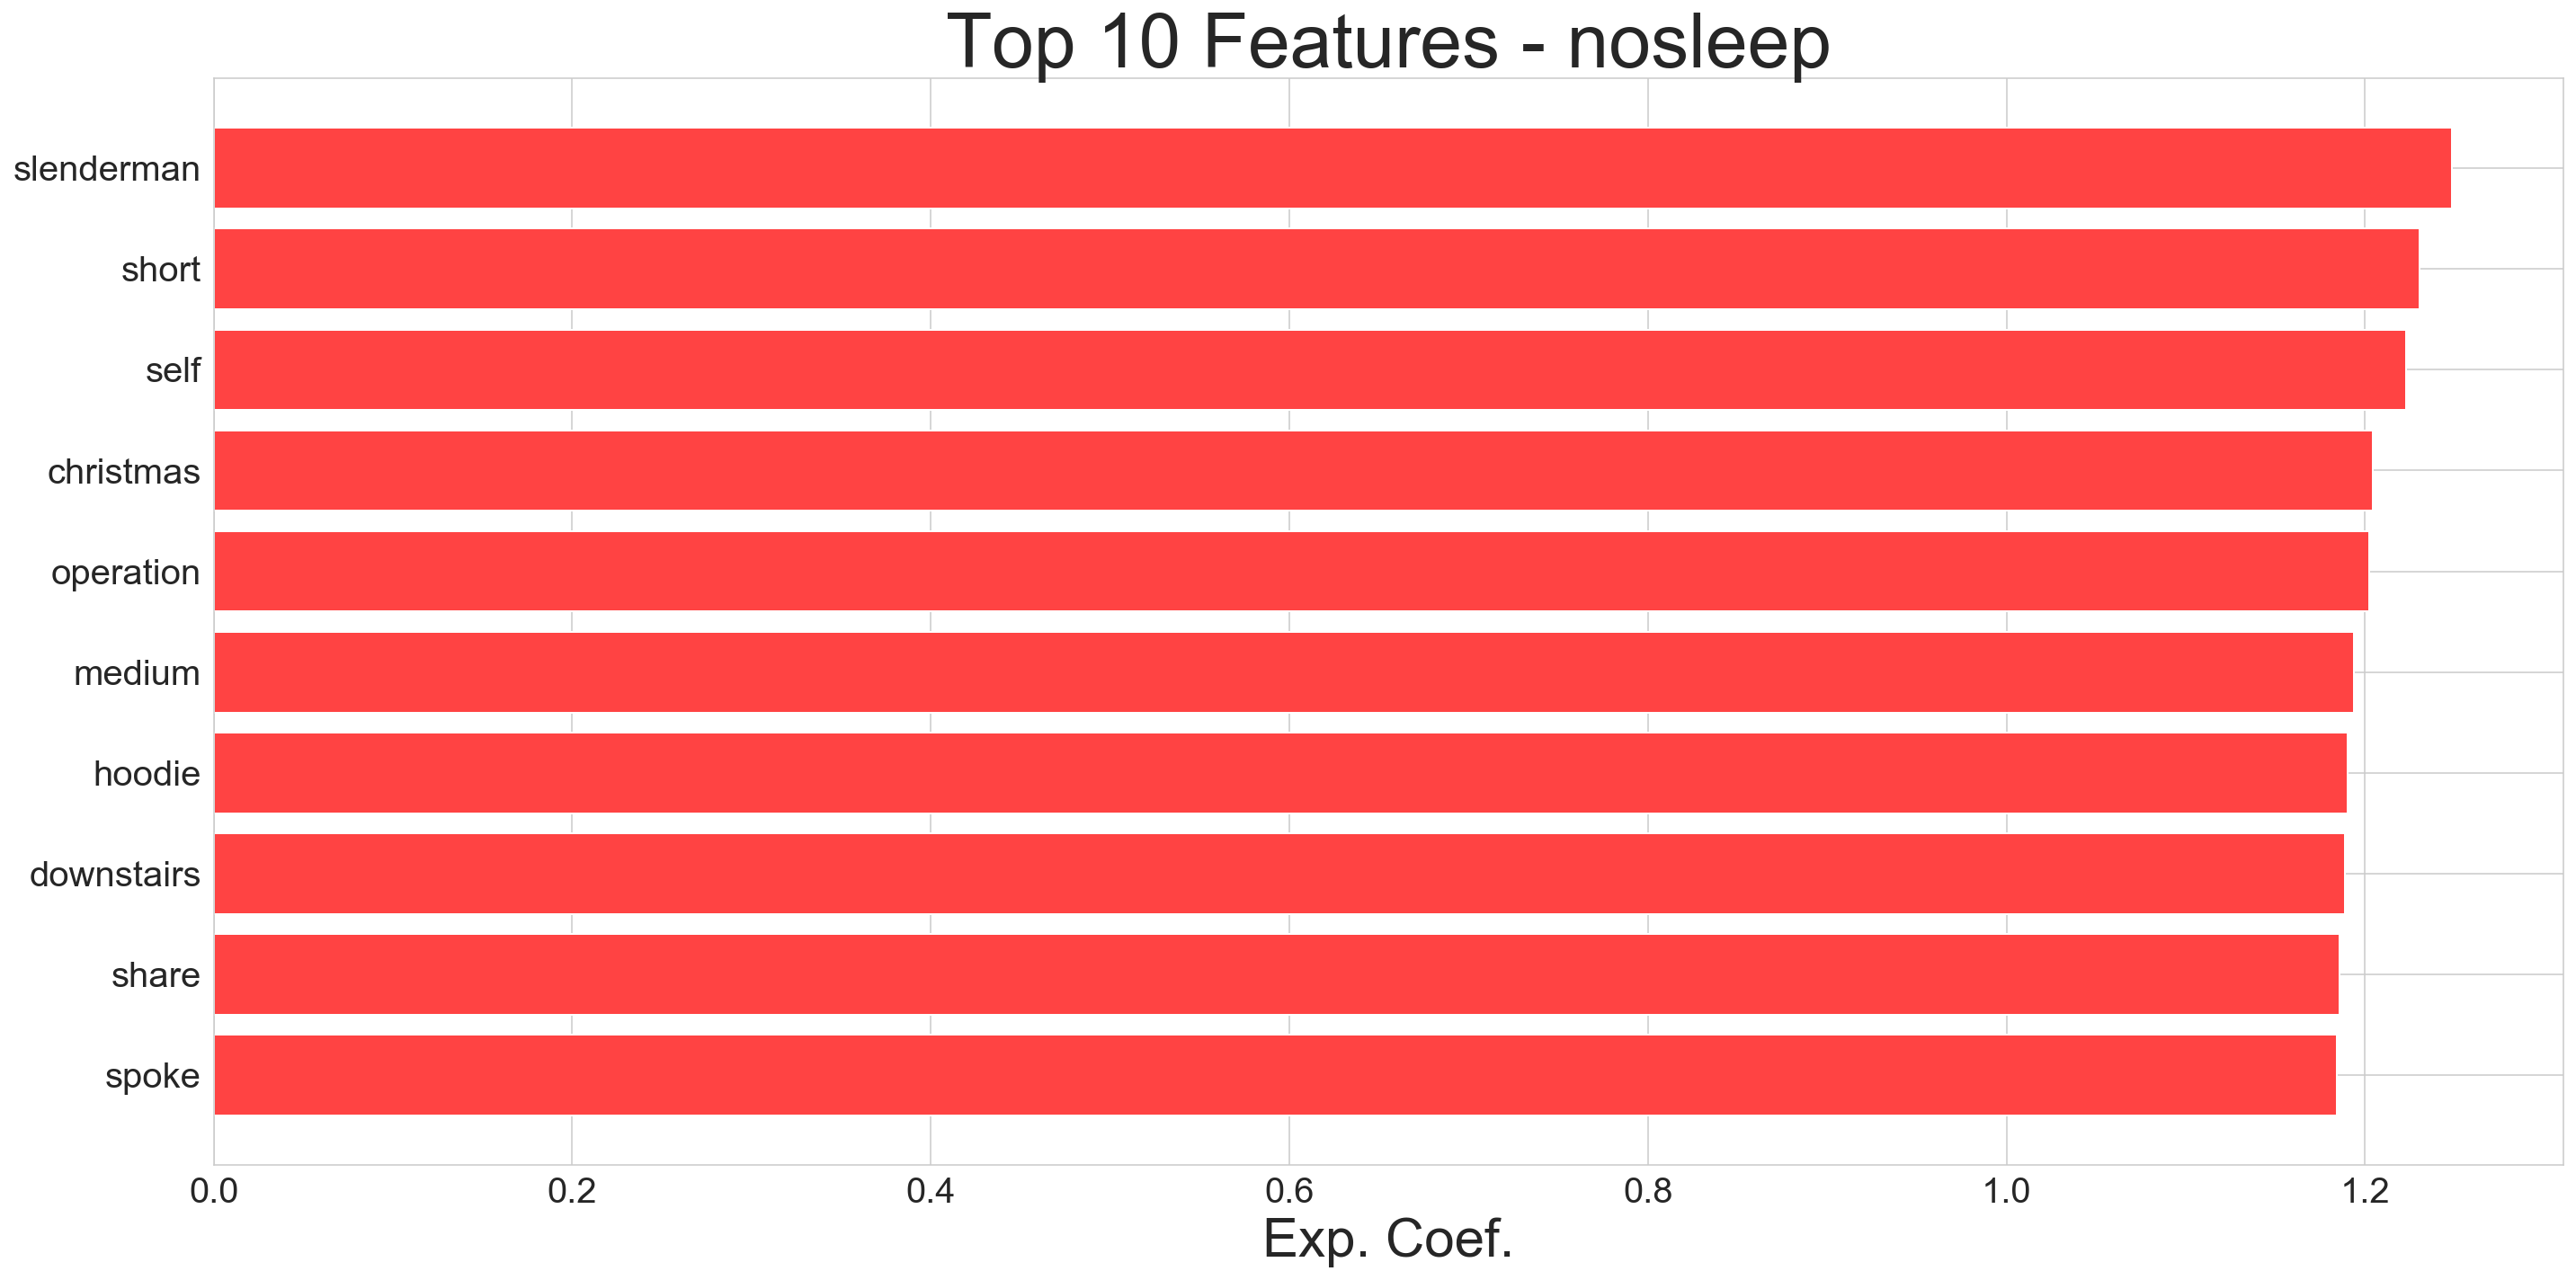

In [55]:
coef_df = pd.DataFrame({'features': features,
             'coefficients': coefs
                         })

coef_df = coef_df[coef_df['features'] != 'utm']
coef_df = coef_df[coef_df['features'] != 'comments']
coef_df = coef_df[coef_df['features'] != 'series']
coef_df = coef_df[coef_df['features'] != 'frank']
coef_df = coef_df[coef_df['features'] != 'clearly']
coef_df = coef_df[coef_df['features'] != 'part']
coef_df = coef_df[coef_df['features'] != 'finding']
coef_df = coef_df[coef_df['features'] != 'narration']
coef_df = coef_df[coef_df['features'] != 'horror']
coef_df = coef_df[coef_df['features'] != 'nearly']

coef_df['absolute_coef'] = abs(coef_df['coefficients'])
coef_df['exp_coef'] = np.exp(coef_df['absolute_coef'])
coef_df = coef_df.sort_values('exp_coef', ascending = False)
coef_df = coef_df.reset_index(drop=True)
coef_df = coef_df.set_index('features')
coef_df = coef_df[coef_df['exp_coef'] != 0] #removes coefficients of 0
coef_df.head(10)
weights = coef_df['exp_coef'].head(10).sort_values()
labels = weights.index
plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = '#FF4343')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Exp. Coef.', fontsize=30)
plt.title(f'Top 10 Features - nosleep', fontsize=42)
plt.tight_layout()
plt.savefig('../images/exp_coef.png')


>As there is a one word increase in our word `'slenderman'`, the reddit post is `1.248377` times as likely to be from the NOSLEEP subreddit.

In [53]:
coef_df['features'] = coef_df.index

coef_df[coef_df['features'] == 'slenderman']

In [28]:
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=42)

In [29]:
# create functions to return just the columns that you care about
get_text_data = FunctionTransformer(lambda x: x['all_text'], validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[['word_count', 'sentiment']], validate=False)


In [30]:
%%time
# create the new pipeline
    # feature union
        # numeric
        # text
            # extract text
            # vectorize
    # model

pipe_v2 = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', get_numeric_data),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('logreg', LogisticRegression())
])

gs = GridSearchCV(pipe_v2, params, cv=5)

gs.fit(X_train, y_train)

# build a function to print out a nice confusion matrix
preds = gs.best_estimator_.predict(X_test)

nice_conmat(y_test, preds, ['creepypasta', 'nosleep'])

/Users/mariaflores/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mariaflores/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaflores/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mariaflores/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaflores/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver

Accuracy Score: 0.7464646464646465
CPU times: user 2min 19s, sys: 1.81 s, total: 2min 21s
Wall time: 1min 38s


,Predicted creepypasta,Predicted nosleep
Actual creepypasta,2048,387
Actual nosleep,868,1647


In [31]:
gs.best_params_

{'logreg__penalty': 'l2'}

>We are able to predict the subreddit 74% of the time.

In [32]:
%%time 
pipe_v3 = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('logreg', LogisticRegression())
])
gs = GridSearchCV(pipe_v3, params, cv=5)
gs.fit(X_train, y_train)

print(f'Best Params:\n{gs.best_params_}')
print(f'Train Score: {gs.score(X_train, y_train)}')
print(f'Test Score: {gs.score(X_test, y_test)}')

/Users/mariaflores/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mariaflores/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaflores/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mariaflores/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mariaflores/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver

Best Params:
{'logreg__penalty': 'l2'}
Train Score: 0.8758081896551724
Test Score: 0.7462626262626263
CPU times: user 2min 52s, sys: 2.25 s, total: 2min 54s
Wall time: 2min 1s


>We are able to predict the subreddit 74% of the time.

- Best Params:
`{'logreg__penalty': 'l2'}`
- Train Score: 0.8758081896551724
- Test Score: 0.7462626262626263

### Best Model
I used a `FeatureUnion` and multiple `Pipelines`. I employed a sentiment analysis column so that I could add it to the features. I used `StandardScaler`, `CountVectorizer`, and `ExtraTreesClassifier` with a range of parameters and ran them through a three-fold `GridSearch` and achieved a training score of '0.9958' and test score of `0.7769`. This means the model can predict the subreddit about 77% of the time.

In [33]:
%%time 
params_v3 = {'et__max_depth': [None], 
             'et__max_features': ['auto'], 
             'et__n_estimators': [125]}

pipe_v3 = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('et', ExtraTreesClassifier())
])
gs = GridSearchCV(pipe_v3, params_v3, cv=3)
gs.fit(X_train, y_train)

print(f'Best Params:\n{gs.best_params_}')
print(f'Train Score: {gs.score(X_train, y_train)}')
print(f'Test Score: {gs.score(X_test, y_test)}')

Best Params:
{'et__max_depth': None, 'et__max_features': 'auto', 'et__n_estimators': 125}
Train Score: 0.9958243534482759
Test Score: 0.776969696969697
CPU times: user 8min 27s, sys: 4.41 s, total: 8min 32s
Wall time: 8min 50s


>- Best Params:
`{'et__max_depth': None, 'et__max_features': 'auto', 'et__n_estimators': 125}`
- Train Score: 0.9958243534482759
- Test Score: 0.776969696969697

### Conclusion and Recommendations

Since the subreddit [`/r/nosleep`](https://www.reddit.com/r/nosleep) has more relevant observations – given its higher average length and the fact that it contains no images – its most important features are stronger indicators of the popular horror stories generated and shared among users. The top feature indicates that as there is a one word increase in the word "slenderman," the reddit post is 1.25 times as likely to be from the [`/r/nosleep`](https://www.reddit.com/r/nosleep) subreddit. Based on the most important feature, I would recommend making a horror film based on the "Slender Man" legend.

The overlapping list of top words offers more ideas for a horror film. In both subreddits, users highly mentioned the words: `['door', 'eyes', 'room', 'man','night', 'day', 'house', 'face', 'head', 'felt', 'people', 'heard', 'thing', 'look', 'little', 'told', 'left']`, which can be important for setting a tone for the different scenes in a movie. The top features list also includes the word `'christmas'`, which highlights a time frame that users popularly share in their accounts of horror.

While processing the stories from the posts, content in the form of videos or images were overlooked, therefore there is value in further investigating those observations. Users highly engage in media content within these subreddits so gathering popular themes from that media could be an idea for another project.
